In [ ]:
#!pip install svgwrite


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cv2
from scipy.spatial import distance
from google.colab import files

In [ ]:

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    print(f"np_path_XYs shape: {np_path_XYs.shape}")

    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            if XY.ndim == 1:
                XY = XY.reshape(-1, 2)
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_and_save(paths_XYs, output_path):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            print(f"XY shape in plot: {XY.shape}")
            if XY.ndim == 1:
                XY = XY.reshape(-1, 2)
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')

    # Save the plot as an image file
    plt.savefig(output_path)
    print(f"Plot saved to {output_path}")

    # Display the plot
    plt.show()

    # Close the figure
    plt.close(fig)



Please upload your CSV file:


Saving occlusion2.csv to occlusion2.csv
np_path_XYs shape: (1636, 4)
XY shape in plot: (58, 2)
XY shape in plot: (67, 2)
XY shape in plot: (485, 2)
XY shape in plot: (378, 2)
XY shape in plot: (648, 2)
Plot saved to input.png


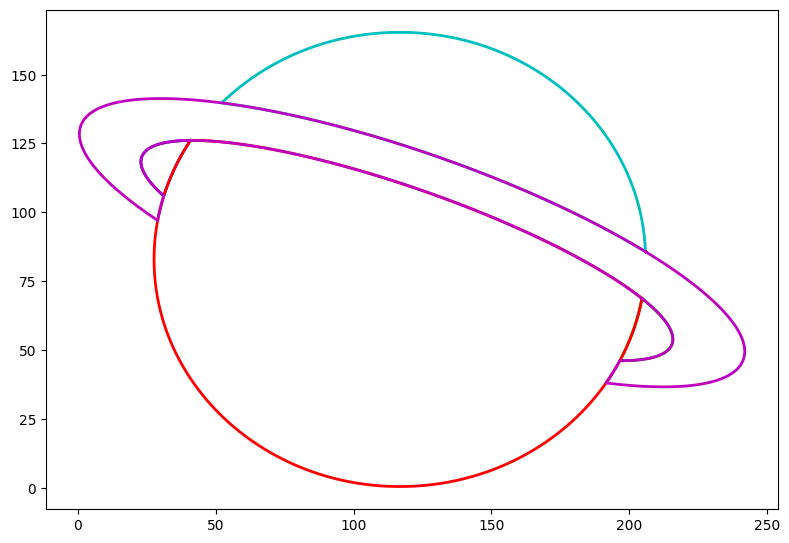

XY shape in plot: (100, 2)
XY shape in plot: (100, 2)
XY shape in plot: (100, 2)
XY shape in plot: (100, 2)
XY shape in plot: (8, 2)
Plot saved to output.png


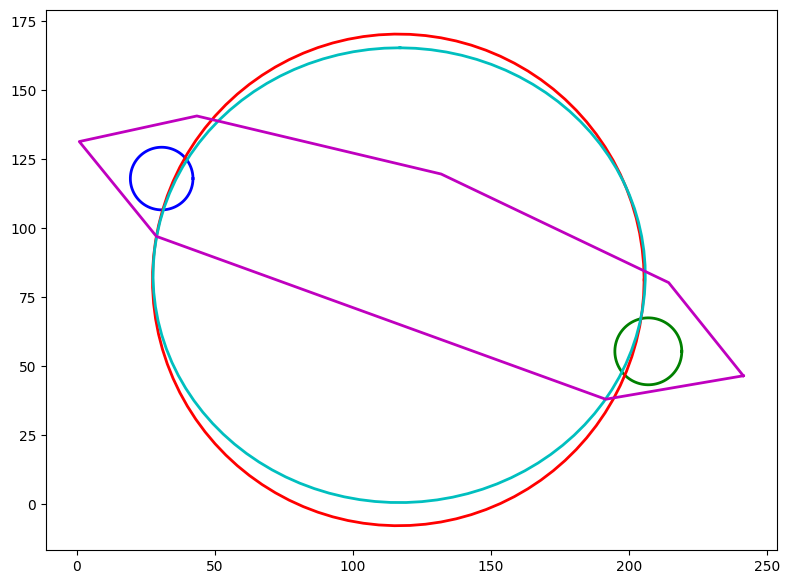

Processing complete. Outputs saved as beautified_curves.csv, output.svg, and output.png


In [ ]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

    for i, path in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in path:
            points = [(int(x), int(y)) for x, y in XY]
            group.add(dwg.polyline(points=points, fill='none', stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()

def identify_shape(XY):
    contour = XY.astype(np.float32)

    if len(XY) < 3:
        return "line", XY

    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)

    area = cv2.contourArea(contour)
    circularity = 4 * np.pi * area / (perimeter ** 2)

    if len(approx) == 3:
        return "triangle", XY
    elif len(approx) == 4:
        rect = cv2.minAreaRect(contour)
        width, height = rect[1]
        if 0.95 < width / height < 1.05:
            return "square", XY
        return "rectangle", XY
    elif len(approx) == 5:
        return "pentagon", XY
    elif 0.8 < circularity < 1.2:
        return "circle", XY
    elif 0.5 < circularity < 0.8:
        return "ellipse", XY
    elif len(approx) > 5:
        return "polygon", XY

    return "curve", XY

def regularize_curves(paths_XYs):
    regularized_paths = []
    for path in paths_XYs:
        regularized_path = []
        for XY in path:
            shape_type, points = identify_shape(XY)
            regularized_curve = regularize_shape(shape_type, points)
            regularized_path.append(regularized_curve)
        regularized_paths.append(regularized_path)
    return regularized_paths

def regularize_shape(shape_type, points):
    if shape_type == "line":
        return points
    elif shape_type in ["triangle", "rectangle", "pentagon", "polygon"]:
        perimeter = cv2.arcLength(points.astype(np.float32), True)
        approx = cv2.approxPolyDP(points.astype(np.float32), 0.01 * perimeter, True)
        return approx.reshape(-1, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points.astype(np.float32))
        theta = np.linspace(0, 2*np.pi, 100)
        improved_circle = np.column_stack([x + radius * np.cos(theta), y + radius * np.sin(theta)])
        return improved_circle
    elif shape_type == "ellipse":
        if len(points) < 5:
            return points
        ellipse = cv2.fitEllipse(points.astype(np.float32))
        center, axes, angle = ellipse
        major_axis, minor_axis = axes
        theta = np.linspace(0, 2*np.pi, 100)
        x = center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle))
        y = center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
        return np.column_stack((x, y))
    else:  # curve
        return points


def detect_symmetry(paths_XYs):
    symmetric_paths = []
    for path in paths_XYs:
        symmetric_path = []
        for XY in path:
            symmetry_lines = find_symmetry_lines(XY)
            if symmetry_lines:
                symmetric_curve = apply_symmetry(XY, symmetry_lines)
                symmetric_path.append(symmetric_curve)
            else:
                symmetric_path.append(XY)
        symmetric_paths.append(symmetric_path)
    return symmetric_paths


def find_symmetry_lines(XY):
    symmetry_lines = []
    contour = XY.astype(np.float32)

    moments = cv2.moments(contour)
    if moments['m00'] == 0:
        return symmetry_lines

    center_x = moments['m10'] / moments['m00']
    center_y = moments['m01'] / moments['m00']

    left = XY[XY[:, 0] <= center_x]
    right = XY[XY[:, 0] >= center_x]
    if len(left) == len(right):
        left_distances = center_x - left[:, 0]
        right_distances = right[:, 0] - center_x
        if np.allclose(left_distances, right_distances, atol=1):
            symmetry_lines.append(("vertical", center_x))

    top = XY[XY[:, 1] <= center_y]
    bottom = XY[XY[:, 1] >= center_y]
    if len(top) == len(bottom):
        top_distances = center_y - top[:, 1]
        bottom_distances = bottom[:, 1] - center_y
        if np.allclose(top_distances, bottom_distances, atol=1):
            symmetry_lines.append(("horizontal", center_y))

    return symmetry_lines

def apply_symmetry(XY, symmetry_lines):
    symmetric_XY = XY.copy()
    for sym_type, sym_value in symmetry_lines:
        if sym_type == "vertical":
            symmetric_XY[:, 0] = 2 * sym_value - symmetric_XY[:, 0]
        elif sym_type == "horizontal":
            symmetric_XY[:, 1] = 2 * sym_value - symmetric_XY[:, 1]
    return symmetric_XY

def complete_curves(paths_XYs):
    completed_paths = []
    for path in paths_XYs:
        completed_path = []
        for XY in path:
            if is_incomplete(XY):
                completed_curve = complete_curve(XY)
                completed_path.append(completed_curve)
            else:
                completed_path.append(XY)
        completed_paths.append(completed_path)
    return completed_paths

def is_incomplete(XY):
    return not np.allclose(XY[0], XY[-1], atol=1)

def complete_curve(XY):
    shape_type, _ = identify_shape(XY)
    if shape_type in ["triangle", "rectangle", "pentagon", "polygon", "circle", "ellipse"]:
        return np.vstack((XY, XY[0]))
    else:  # curve
        return XY

def beautify_curves(paths_XYs):
    beautified_paths = []
    for path in paths_XYs:
        beautified_path = []
        for XY in path:
            shape_type, _ = identify_shape(XY)
            beautified_curve = regularize_shape(shape_type, XY)
            if shape_type in ["triangle", "rectangle", "pentagon", "polygon", "circle", "ellipse"]:
                if not np.allclose(beautified_curve[0], beautified_curve[-1]):
                    beautified_curve = np.vstack((beautified_curve, beautified_curve[0]))
            beautified_path.append(beautified_curve)
        beautified_paths.append(beautified_path)
    return beautified_paths

def save_to_csv(paths_XYs, filename):
    with open(filename, 'w') as f:
        for i, path_XYs in enumerate(paths_XYs):
            for j, XY in enumerate(path_XYs):
                for x, y in XY:
                    f.write(f"{i},{j},{x},{y}\n")

def occlusion_completion(paths_XYs):
    completed_paths = []
    for path in paths_XYs:
        completed_path = []
        for XY in path:
            shape_type, _ = identify_shape(XY)
            if is_occluded(XY, shape_type):
                completed_curve = complete_occluded_shape(XY, shape_type)
                completed_path.append(completed_curve)
            else:
                completed_path.append(XY)
        completed_paths.append(completed_path)
    return completed_paths

def is_occluded(XY, shape_type):
    if shape_type in ["circle", "ellipse"]:
        return not np.allclose(XY[0], XY[-1], atol=1)
    elif shape_type in ["triangle", "rectangle", "pentagon", "polygon"]:
        return not np.allclose(XY[0], XY[-1], atol=1)
    else:
        distances = np.linalg.norm(np.diff(XY, axis=0), axis=1)
        return np.any(distances > np.mean(distances) * 3)

def complete_occluded_shape(XY, shape_type):
    if shape_type in ["circle", "ellipse"]:
        return complete_ellipse(XY)
    elif shape_type in ["triangle", "rectangle", "pentagon", "polygon"]:
        return complete_polygon(XY)
    else:
        return complete_curve(XY)

def complete_ellipse(XY):
    if len(XY) < 5:
        return XY
    ellipse = cv2.fitEllipse(XY.astype(np.float32))
    center, axes, angle = ellipse
    major_axis, minor_axis = axes
    theta = np.linspace(0, 2*np.pi, 100)
    x = center[0] + major_axis / 2 * np.cos(theta) * np.cos(np.radians(angle)) - minor_axis / 2 * np.sin(theta) * np.sin(np.radians(angle))
    y = center[1] + major_axis / 2 * np.cos(theta) * np.sin(np.radians(angle)) + minor_axis / 2 * np.sin(theta) * np.cos(np.radians(angle))
    return np.column_stack((x, y))

def complete_polygon(XY):
    hull = cv2.convexHull(XY.astype(np.float32))
    return hull.reshape(-1, 2)

def complete_curve(XY):
    t = np.linspace(0, 1, len(XY))
    t_new = np.linspace(0, 1, len(XY) * 2)
    x_interp = np.interp(t_new, t, XY[:, 0])
    y_interp = np.interp(t_new, t, XY[:, 1])
    return np.column_stack((x_interp, y_interp))


def main():
    print("Please upload your CSV file:")
    uploaded = files.upload()

    # Extract the filename and read the CSV
    input_file = next(iter(uploaded))
    paths_XYs = read_csv(input_file)

    # Initial plotting of input data
    plot_and_save(paths_XYs, "input.png")

    # Process the curves to regularize and detect symmetry
    regularized_paths = regularize_curves(paths_XYs)
    symmetric_paths = detect_symmetry(regularized_paths)

    # Check for occlusions
    occluded = any(is_occluded(XY, identify_shape(XY)[0]) for path in symmetric_paths for XY in path)

    if occluded:
        # Apply occlusion completion
        completed_paths = occlusion_completion(symmetric_paths)
    else:
        # Skip occlusion completion
        completed_paths = symmetric_paths

    # Beautify the curves
    beautified_paths = beautify_curves(completed_paths)

    # Save beautified curves as CSV
    save_to_csv(beautified_paths, "beautified_curves.csv")

    # Save beautified curves as SVG
    polylines2svg(beautified_paths, "output.svg")

    # Save beautified curves as a single image
    plot_and_save(beautified_paths, "output.png")

    print("Processing complete. Outputs saved as beautified_curves.csv, output.svg, and output.png")

if __name__ == "__main__":
    main()
